In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [3]:
# COCO dataset path
coco_dataset_path = "/kaggle/input/coco-2017-dataset/coco2017"


In [4]:
# COCO dataset annotations path
annotations_path = os.path.join(coco_dataset_path, "annotations")
images_path = os.path.join(coco_dataset_path, "val2017")

In [5]:
# Load COCO dataset filepaths and labels
filepaths_coco =list(Path(images_path).rglob("*.jpg"))
labels_coco = ['COCO' for _ in range(len(filepaths_coco))]

In [6]:
# diabetic retinopathy dataset path
diabetic_retinopathy_path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered"

In [7]:
# Load diabetic retinopathy filepaths and labels
image_dir_diabetic = Path(diabetic_retinopathy_path)
filepaths_diabetic = list(image_dir_diabetic.glob(r'**/*.png'))
labels_diabetic = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_diabetic))


In [8]:
# Concatenate the datasets
filepaths = filepaths_coco + filepaths_diabetic
labels = labels_coco + labels_diabetic

In [9]:
# Sample image categories and counts
categories = ['No_DR', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR', 'COCO']
counts = [1805, 370, 999, 295, 193, len(filepaths_coco)]

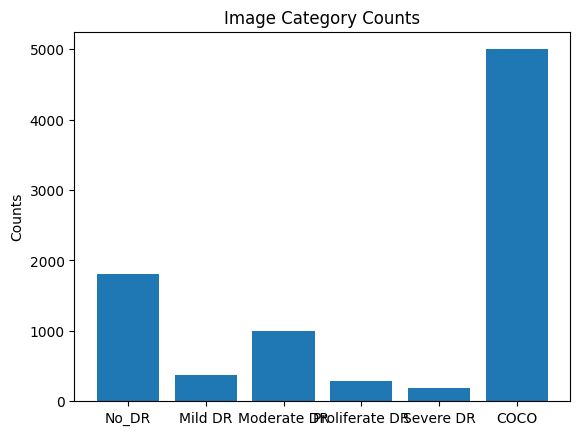

In [10]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis labels as the image categories
x = np.arange(len(categories))
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Plot the counts as bars
ax.bar(x, counts)

# Set the y-axis label
ax.set_ylabel('Counts')

# Set the title of the bar graph
ax.set_title('Image Category Counts')

# Show the plot
plt.show()

In [11]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/kaggle/input/coco-2017-dataset/coco2017/val20...,COCO
1,/kaggle/input/coco-2017-dataset/coco2017/val20...,COCO
2,/kaggle/input/coco-2017-dataset/coco2017/val20...,COCO
3,/kaggle/input/diabetic-retinopathy-224x224-gau...,Moderate
4,/kaggle/input/coco-2017-dataset/coco2017/val20...,COCO


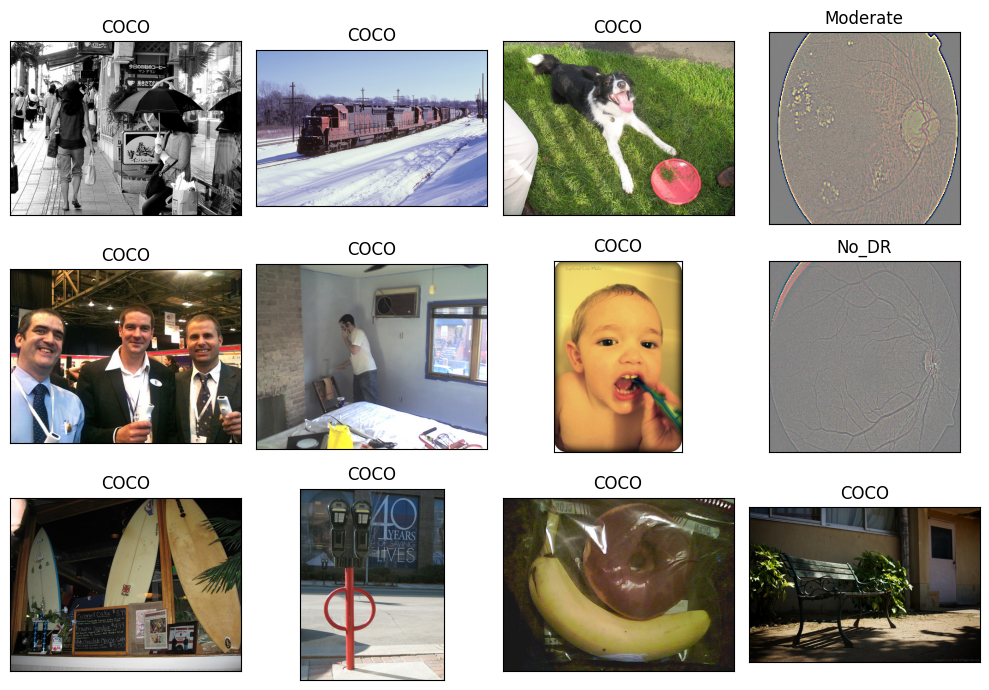

In [12]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

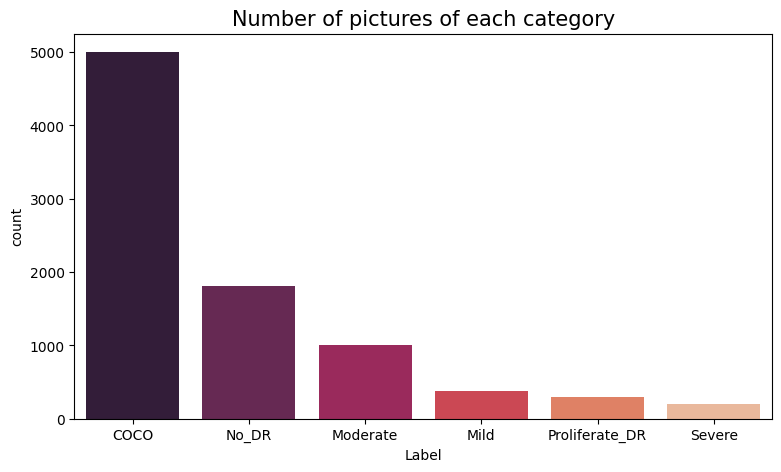

In [13]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [14]:
import tensorflow as tf
import keras.backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Calculate binary cross entropy
        binary_cross_entropy = K.binary_crossentropy(y_true, y_pred)

        # Calculate the modulating factor
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        modulating_factor = K.pow(1 - p_t, gamma)

        # Calculate the final loss
        focal_loss = alpha * modulating_factor * binary_cross_entropy

        return focal_loss

    return focal_loss_fixed

In [15]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [16]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    initial_learning_rate = 0.001
    optimizer = keras.optimizers.SGD(learning_rate=initial_learning_rate)  

    model.compile(
        optimizer= optimizer,
        #loss='categorical_crossentropy'
        loss= focal_loss(),
        metrics=['accuracy']
    )
    
    return model

In [17]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Load and preprocess the data
train_generator, test_generator, train_images, val_images, test_images = create_gen()

Found 7016 validated image filenames belonging to 6 classes.
Found 779 validated image filenames belonging to 6 classes.
Found 867 validated image filenames belonging to 6 classes.


In [20]:
# Define Mixup augmentation function
def mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    lam = tf.random.uniform([batch_size], 0, 1)
    lam = tf.maximum(lam, 1 - lam)
    
    mix_images = lam[:, tf.newaxis, tf.newaxis, tf.newaxis] * images + (1 - lam[:, tf.newaxis, tf.newaxis, tf.newaxis]) * tf.reverse(images, axis=[0])
    mix_labels = lam[:, tf.newaxis] * labels + (1 - lam[:, tf.newaxis]) * labels[::-1]
    return mix_images, mix_labels

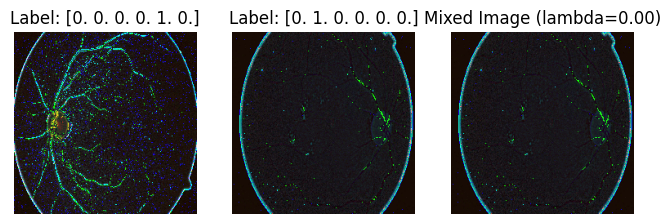

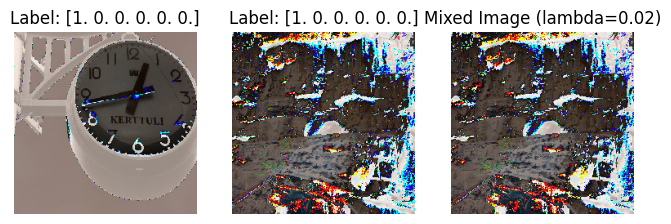

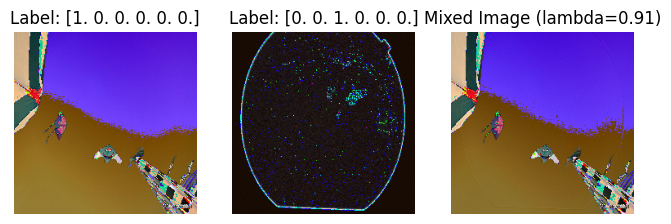

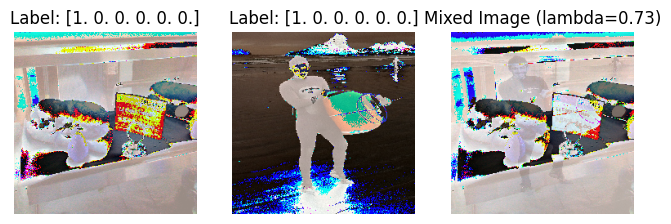

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Create a function to display mixed images
def display_mixup_images(generator, num_images=4):
    for _ in range(num_images):
        # Generate a batch of mixed images and labels
        x, y = next(generator)

        # Take the first two images from the batch
        image1, image2 = x[:2]
        label1, label2 = y[:2]

        # Calculate the Mixup weight (lambda)
        lam = np.random.beta(0.2, 0.2)  # You can adjust these parameters

        # Mix the two images
        mixed_image = (lam * image1) + ((1 - lam) * image2)

        # Display the mixed image
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"Label: {label1}")
        plt.imshow(image1.astype(np.uint8))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title(f"Label: {label2}")
        plt.imshow(image2.astype(np.uint8))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f"Mixed Image (lambda={lam:.2f})")
        plt.imshow(mixed_image.astype(np.uint8))
        plt.axis('off')

        plt.show()

# Use the function to display mixed images
display_mixup_images(train_images)


In [35]:
# Define evaluation functions
def evaluate_model(model, test_images):
    y_true = test_images.classes
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=categories))
    
    # Compute ROC curve and AUC for each class
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(categories)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(categories)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{categories[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    
    plt.tight_layout()
    plt.show()
    
    
    # CONFUSION
    cm = confusion_matrix(y_true, y_pred_classes)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [36]:
def create_gen(train_df, val_df):
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,  # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,  # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    return train_generator, test_generator, train_images, val_images

In [37]:
from sklearn.model_selection import StratifiedKFold

In [41]:
# Create and preprocess the data generators for this fold
train_generator_fold, _, train_images_fold, val_images_fold = create_gen(train_df_fold, val_df_fold)

Found 6237 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.


In [42]:
k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

Fold 1/5
Found 6237 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Epoch 1/50


I0000 00:00:1707150620.804356     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 - 120s - loss: 0.0415 - accuracy: 0.0718 - val_loss: 0.0352 - val_accuracy: 0.1214 - 120s/epoch - 1s/step
Epoch 2/50
98/98 - 71s - loss: 0.0311 - accuracy: 0.1990 - val_loss: 0.0275 - val_accuracy: 0.2750 - 71s/epoch - 730ms/step
Epoch 3/50
98/98 - 71s - loss: 0.0250 - accuracy: 0.3377 - val_loss: 0.0228 - val_accuracy: 0.3904 - 71s/epoch - 722ms/step
Epoch 4/50
98/98 - 73s - loss: 0.0212 - accuracy: 0.4400 - val_loss: 0.0198 - val_accuracy: 0.4821 - 73s/epoch - 749ms/step
Epoch 5/50
98/98 - 73s - loss: 0.0187 - accuracy: 0.5150 - val_loss: 0.0176 - val_accuracy: 0.5485 - 73s/epoch - 741ms/step
Epoch 6/50
98/98 - 72s - loss: 0.0168 - accuracy: 0.5782 - val_loss: 0.0160 - val_accuracy: 0.6033 - 72s/epoch - 740ms/step
Epoch 7/50
98/98 - 71s - loss: 0.0153 - accuracy: 0.6275 - val_loss: 0.0147 - val_accuracy: 0.6477 - 71s/epoch - 727ms/step
Epoch 8/50
98/98 - 70s - loss: 0.0142 - accuracy: 0.6651 - val_loss: 0.0136 - val_accuracy: 0.6787 - 70s/epoch - 712ms/step
Epoch 9/50
98/98 - 7

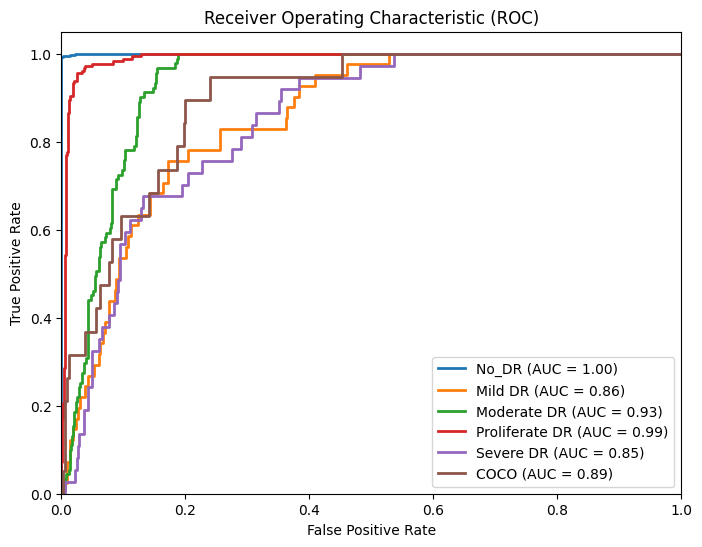

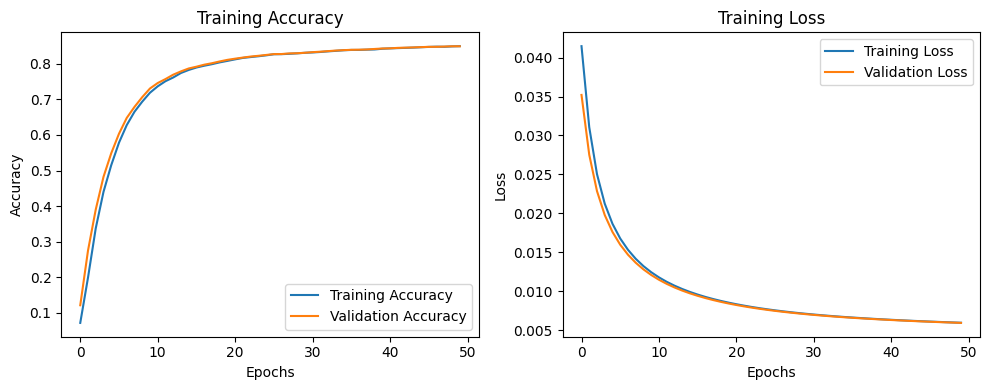

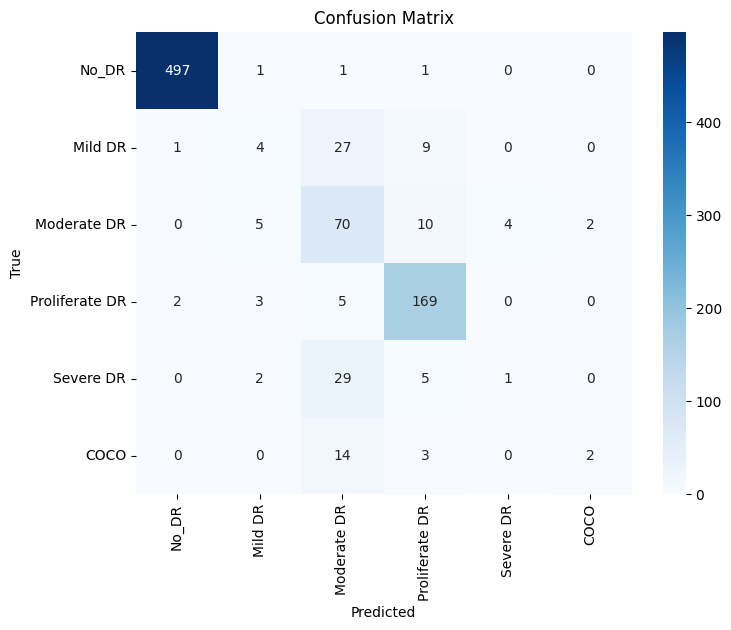

Fold 2/5
Found 6237 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Epoch 1/50
98/98 - 81s - loss: 0.0298 - accuracy: 0.2732 - val_loss: 0.0259 - val_accuracy: 0.2987 - 81s/epoch - 822ms/step
Epoch 2/50
98/98 - 69s - loss: 0.0231 - accuracy: 0.3329 - val_loss: 0.0209 - val_accuracy: 0.3643 - 69s/epoch - 704ms/step
Epoch 3/50
98/98 - 70s - loss: 0.0191 - accuracy: 0.4077 - val_loss: 0.0178 - val_accuracy: 0.4446 - 70s/epoch - 714ms/step
Epoch 4/50
98/98 - 70s - loss: 0.0166 - accuracy: 0.4951 - val_loss: 0.0158 - val_accuracy: 0.5315 - 70s/epoch - 711ms/step
Epoch 5/50
98/98 - 70s - loss: 0.0149 - accuracy: 0.5732 - val_loss: 0.0143 - val_accuracy: 0.5940 - 70s/epoch - 711ms/step
Epoch 6/50
98/98 - 69s - loss: 0.0137 - accuracy: 0.6293 - val_loss: 0.0132 - val_accuracy: 0.6471 - 69s/epoch - 701ms/step
Epoch 7/50
98/98 - 70s - loss: 0.0127 - accuracy: 0.6689 - val_loss: 0.0124 - val_accuracy: 0.6832 - 70s/epoch - 713ms/step
Ep

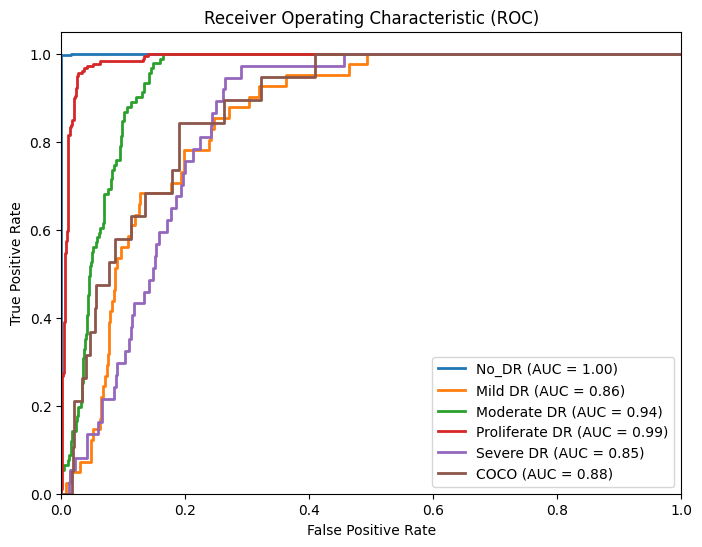

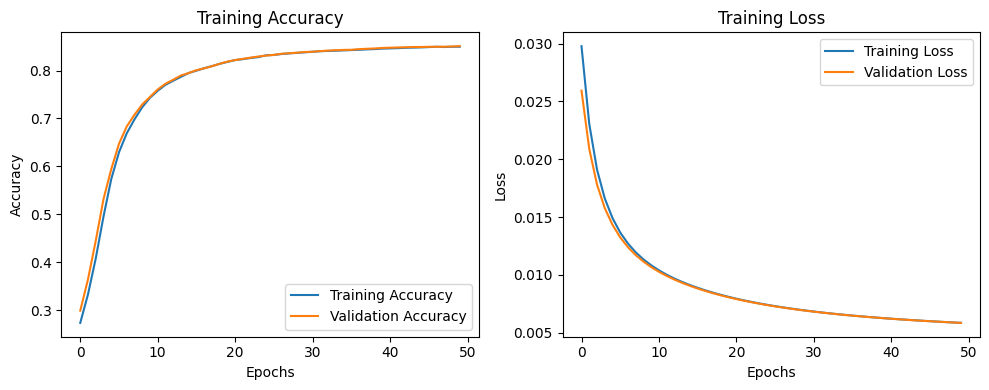

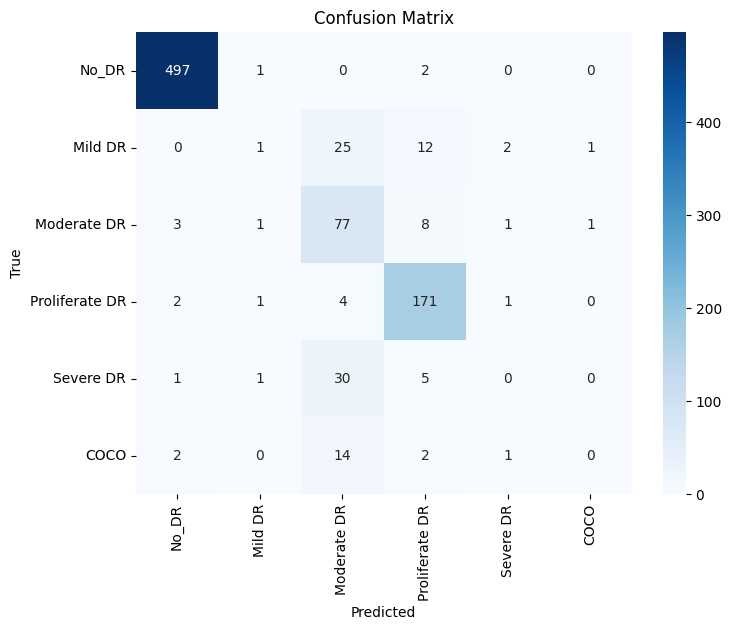

Fold 3/5
Found 6237 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Epoch 1/50
98/98 - 71s - loss: 0.0312 - accuracy: 0.3228 - val_loss: 0.0263 - val_accuracy: 0.3678 - 71s/epoch - 720ms/step
Epoch 2/50
98/98 - 68s - loss: 0.0236 - accuracy: 0.4204 - val_loss: 0.0216 - val_accuracy: 0.4667 - 68s/epoch - 698ms/step
Epoch 3/50
98/98 - 69s - loss: 0.0199 - accuracy: 0.5124 - val_loss: 0.0187 - val_accuracy: 0.5495 - 69s/epoch - 701ms/step
Epoch 4/50
98/98 - 69s - loss: 0.0176 - accuracy: 0.5807 - val_loss: 0.0167 - val_accuracy: 0.6057 - 69s/epoch - 705ms/step
Epoch 5/50
98/98 - 69s - loss: 0.0158 - accuracy: 0.6301 - val_loss: 0.0152 - val_accuracy: 0.6481 - 69s/epoch - 708ms/step
Epoch 6/50
98/98 - 69s - loss: 0.0145 - accuracy: 0.6649 - val_loss: 0.0140 - val_accuracy: 0.6840 - 69s/epoch - 706ms/step
Epoch 7/50
98/98 - 68s - loss: 0.0134 - accuracy: 0.6952 - val_loss: 0.0130 - val_accuracy: 0.7106 - 68s/epoch - 691ms/step
Ep

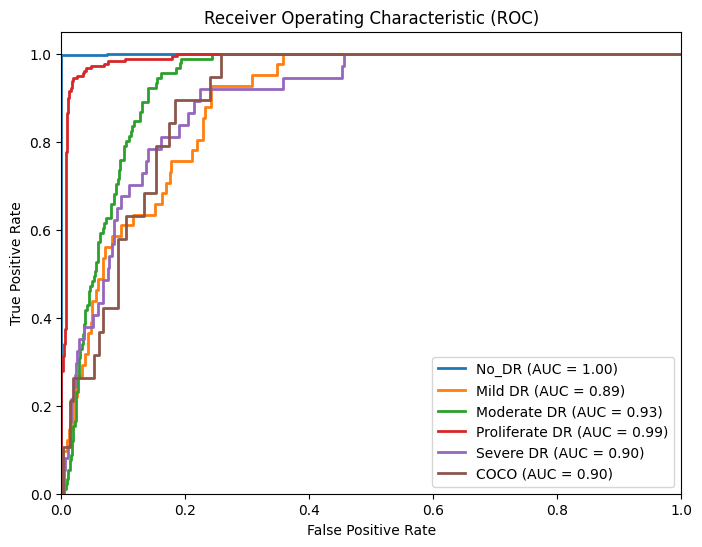

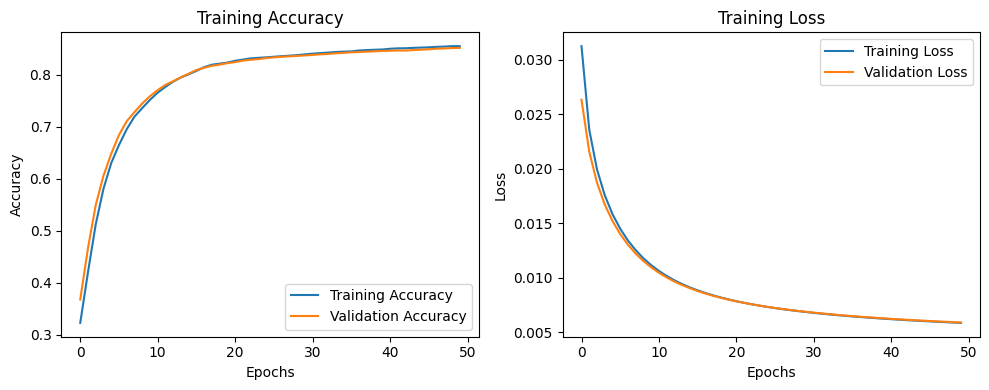

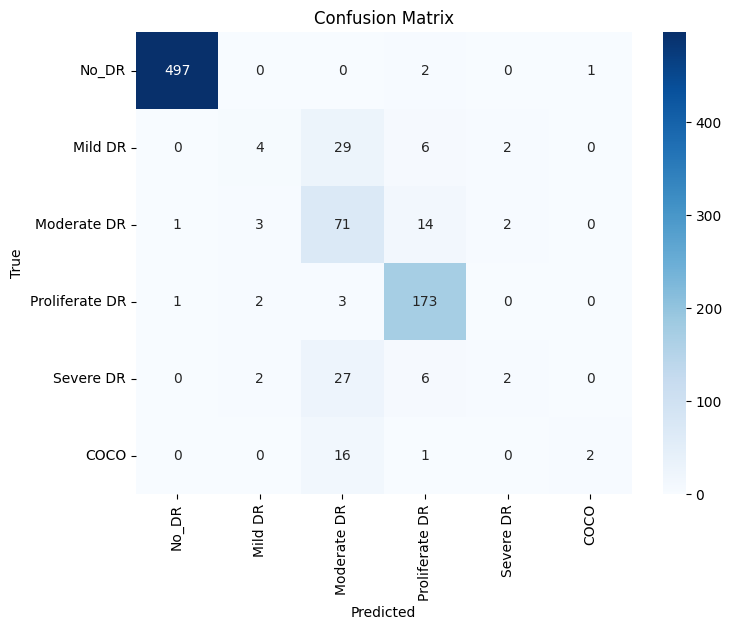

Fold 4/5
Found 6237 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Epoch 1/50
98/98 - 74s - loss: 0.0261 - accuracy: 0.2822 - val_loss: 0.0227 - val_accuracy: 0.3226 - 74s/epoch - 756ms/step
Epoch 2/50
98/98 - 68s - loss: 0.0204 - accuracy: 0.3702 - val_loss: 0.0187 - val_accuracy: 0.4024 - 68s/epoch - 693ms/step
Epoch 3/50
98/98 - 68s - loss: 0.0173 - accuracy: 0.4419 - val_loss: 0.0162 - val_accuracy: 0.4711 - 68s/epoch - 697ms/step
Epoch 4/50
98/98 - 68s - loss: 0.0152 - accuracy: 0.5046 - val_loss: 0.0144 - val_accuracy: 0.5281 - 68s/epoch - 689ms/step
Epoch 5/50
98/98 - 68s - loss: 0.0137 - accuracy: 0.5570 - val_loss: 0.0132 - val_accuracy: 0.5766 - 68s/epoch - 699ms/step
Epoch 6/50
98/98 - 68s - loss: 0.0126 - accuracy: 0.6013 - val_loss: 0.0122 - val_accuracy: 0.6154 - 68s/epoch - 691ms/step
Epoch 7/50
98/98 - 68s - loss: 0.0118 - accuracy: 0.6372 - val_loss: 0.0115 - val_accuracy: 0.6476 - 68s/epoch - 697ms/step
Ep

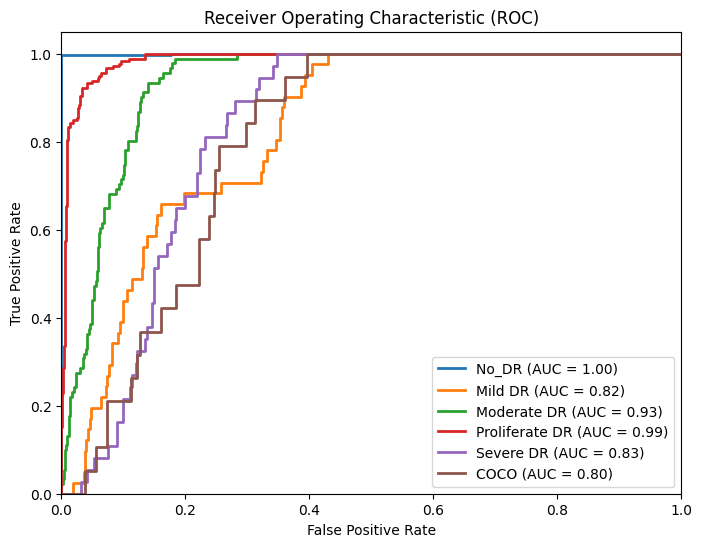

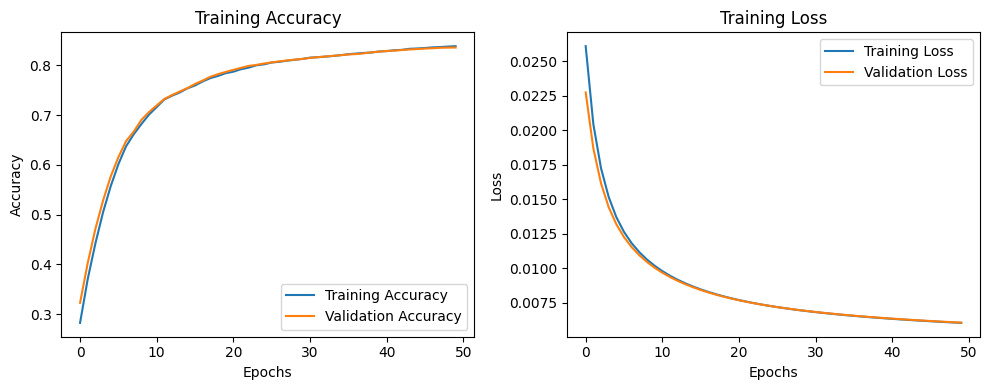

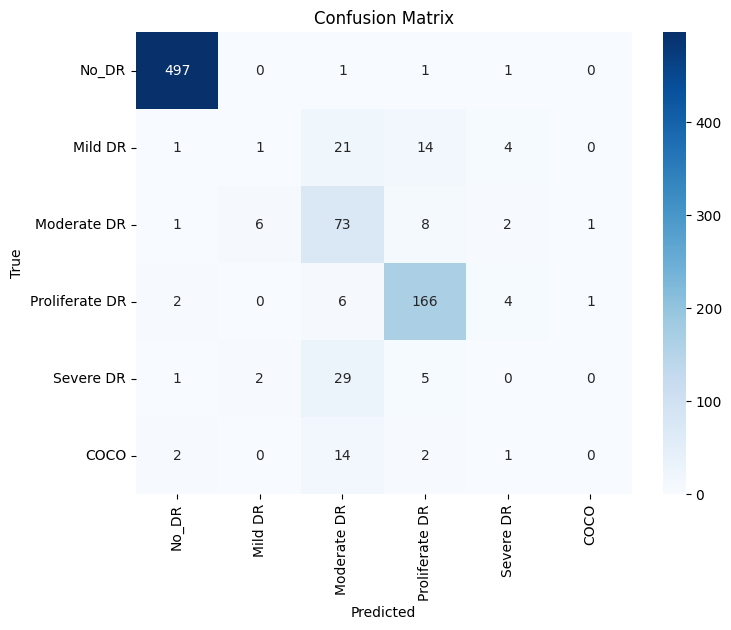

Fold 5/5
Found 6237 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Epoch 1/50
98/98 - 73s - loss: 0.0549 - accuracy: 0.0550 - val_loss: 0.0398 - val_accuracy: 0.0744 - 73s/epoch - 748ms/step
Epoch 2/50
98/98 - 69s - loss: 0.0328 - accuracy: 0.1304 - val_loss: 0.0274 - val_accuracy: 0.2023 - 69s/epoch - 703ms/step
Epoch 3/50
98/98 - 69s - loss: 0.0242 - accuracy: 0.2682 - val_loss: 0.0215 - val_accuracy: 0.3346 - 69s/epoch - 701ms/step
Epoch 4/50
98/98 - 69s - loss: 0.0198 - accuracy: 0.3949 - val_loss: 0.0182 - val_accuracy: 0.4539 - 69s/epoch - 702ms/step
Epoch 5/50
98/98 - 68s - loss: 0.0170 - accuracy: 0.5057 - val_loss: 0.0159 - val_accuracy: 0.5487 - 68s/epoch - 696ms/step
Epoch 6/50
98/98 - 68s - loss: 0.0151 - accuracy: 0.5833 - val_loss: 0.0143 - val_accuracy: 0.6141 - 68s/epoch - 696ms/step
Epoch 7/50
98/98 - 70s - loss: 0.0137 - accuracy: 0.6461 - val_loss: 0.0131 - val_accuracy: 0.6704 - 70s/epoch - 711ms/step
Ep

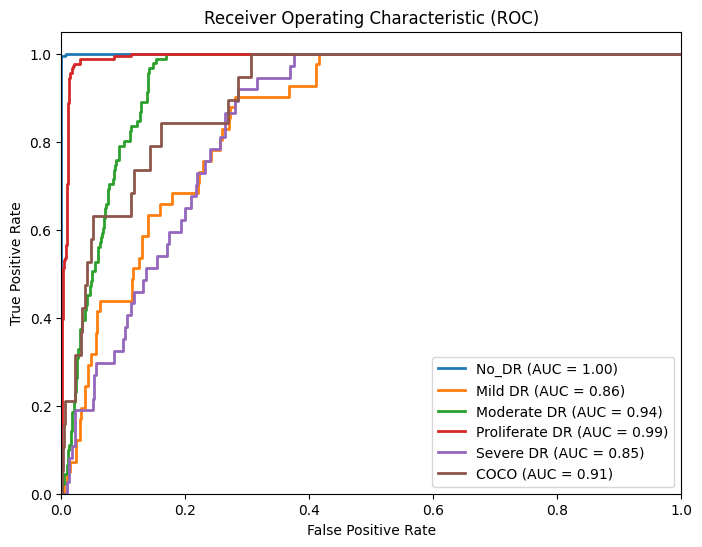

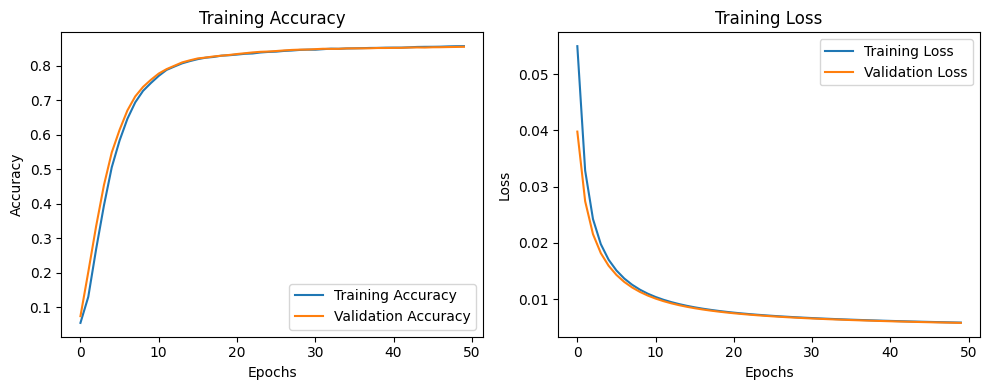

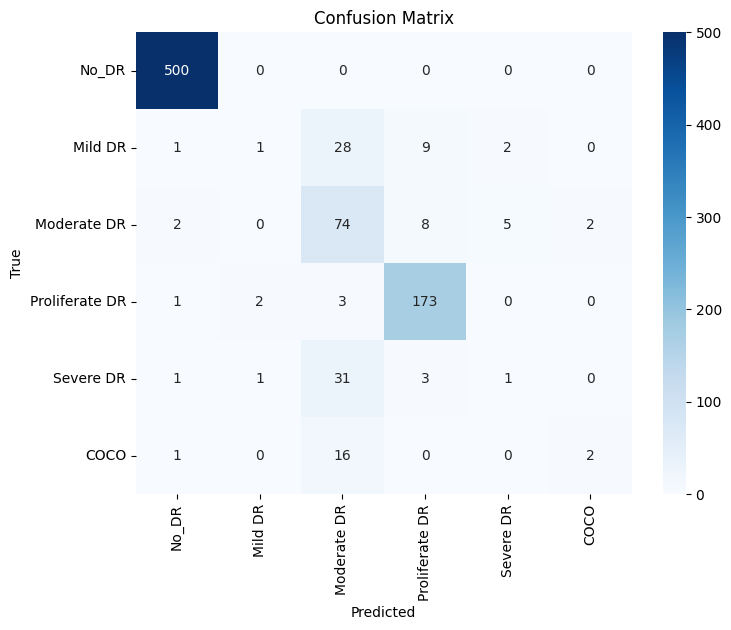

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import  ResNet50

# Initialize a list to store the results for each fold
fold_results = []

# Initialize variables to keep track of the best model
best_model = None
best_val_loss = float('inf')  # Set to positive infinity initially

# Loop over the folds
for fold, (train_index, val_index) in enumerate(skf.split(filepaths, labels)):
    print(f"Fold {fold + 1}/{k}")
    
    train_filepaths = filepaths[train_index]
    val_filepaths = filepaths[val_index]
    train_labels = labels[train_index]
    val_labels = labels[val_index]
    
    train_df_fold = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
    val_df_fold = pd.DataFrame({'Filepath': val_filepaths, 'Label': val_labels})
    
    # Create and preprocess the data generators for this fold
    train_generator_fold, _, val_images_fold, test_images_fold = create_gen(train_df_fold, val_df_fold)

    
    # Create the model for this fold
    model = get_model(ResNet50)  
    
    # Train the model for a fixed number of epochs
    history = model.fit(
        train_images_fold,
        epochs=50,
        validation_data=val_images_fold,
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )
    
    # Evaluate the model on the test data
    evaluate_model(model, test_images)
    
    # Check if the current model's validation loss is better than the best model so far
    if history.history['val_loss'][-1] < best_val_loss:
        best_model = model
        best_val_loss = history.history['val_loss'][-1]
    
    # Append the evaluation results to the fold_results list
    fold_results.append(history)

# Save the best model
best_model.save("best_model_ResNet50.h5")


In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

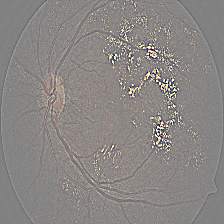

In [45]:
model_builder = keras.applications.ResNet50
img_size = (224, 224)  # ResNet50 uses (224, 224) input size
preprocess_input = keras.applications.resnet.preprocess_input
decode_predictions = keras.applications.resnet.decode_predictions

last_conv_layer_name = "conv5_block3_out"

# The local path to our target image
img_path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/15e96e848b46.png"


display(Image(img_path))

In [46]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

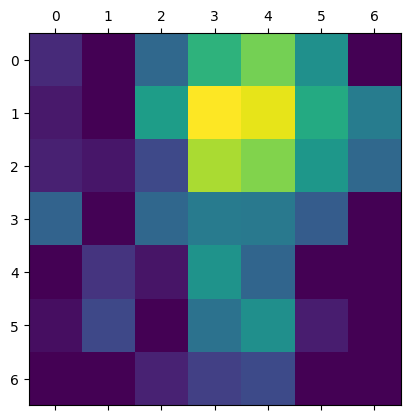

In [47]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model


model = get_model(model_builder)



# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare the image
img_array = keras.applications.resnet.preprocess_input(get_img_array(img_path, size=img_size))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad-CAM result
#save_and_display_gradcam(img_path, heatmap)


/tmp/ipykernel_34/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


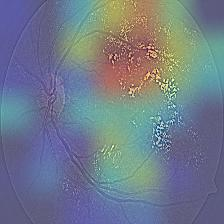

In [48]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [53]:
model.save("ResNet_co_224.h5")

TypeError: argument of type 'NoneType' is not iterable